In [2]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2

In [3]:
# append sys.path
import sys
sys.path.append('../src')
sys.path.append('./src')

from pathlib import Path

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, infer, prepare_for_sbi, simulate_for_sbi
from sbi.simulators.linear_gaussian import diagonal_linear_gaussian

## HH model

tensor([ 5.0000e+00, -7.0132e+01,  2.0194e-02, -5.9107e+01,  2.6467e+02,
         2.5377e+00,  1.3975e+01], dtype=torch.float64)


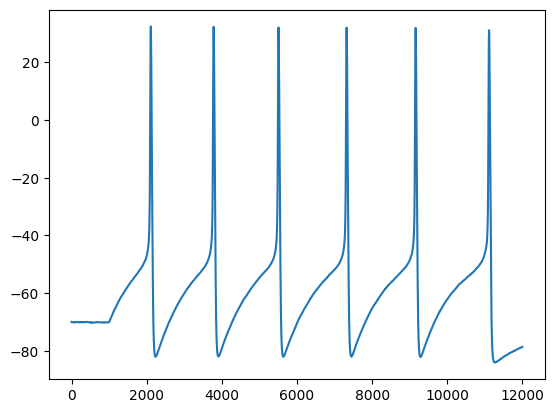

In [7]:
from utils.HH_helper_functions import HHsimulator
from utils.HH_helper_functions import syn_current
from utils.HH_helper_functions import calculate_summary_statistics

params = np.array([[50.0, 1.0], [4.0, 1.5], [20.0, 15.0]])
params = params[2,:]

I, t_on, t_off, dt, t, A_soma = syn_current()
# params = np.asarray(params)
t = np.arange(0, len(I), 1) * dt

# initial voltage
V0 = -70

states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)
obs = dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))
summstats = torch.as_tensor(calculate_summary_statistics(obs))

# return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))
plt.plot(states)
print(summstats)

In [9]:
def run_HH_model(params):

    params = np.asarray(params)

    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1) * dt

    # initial voltage
    V0 = -70

    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.

    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

prior_min = [0.5, 1e-4]
prior_max = [80.0, 15.0]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

posterior, theta, x = infer(
    simulation_wrapper, prior, method="SNPE", num_simulations=300, num_workers=4
)


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 204 epochs.

In [13]:
theta.shape, x.shape

(torch.Size([300, 2]), torch.Size([300, 7]))

In [23]:
# show numpy array with a precision of 3 decimals
np.set_printoptions(precision=3)

In [24]:
observation_summary_statistics

array([ 5.000e+00, -7.012e+01,  9.973e-02, -5.648e+01,  3.754e+02,
        3.706e+00,  1.833e+01])

In [ ]:
[5, -70.12, 0.0997, -56.5, 375.4, 3.706, 18.33]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

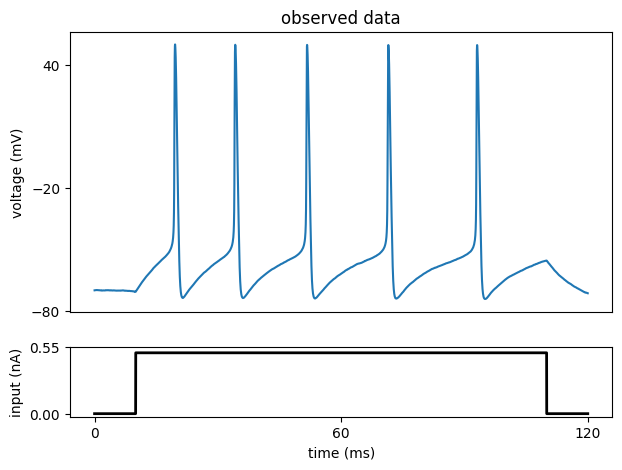

In [11]:
# true parameters and respective labels
true_params = np.array([50.0, 5.0])
labels_params = [r"$g_{Na}$", r"$g_{K}$"]

observation_trace = run_HH_model(true_params)
observation_summary_statistics = calculate_summary_statistics(observation_trace)

fig = plt.figure(figsize=(7, 5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
plt.plot(observation_trace["time"], observation_trace["data"])
plt.ylabel("voltage (mV)")
plt.title("observed data")
plt.setp(ax, xticks=[], yticks=[-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(observation_trace["time"], I * A_soma * 1e3, "k", lw=2)
plt.xlabel("time (ms)")
plt.ylabel("input (nA)")

ax.set_xticks([0, max(observation_trace["time"]) / 2, max(observation_trace["time"])])
ax.set_yticks([0, 1.1 * np.max(I * A_soma * 1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))

samples = posterior.sample((10000,), x=observation_summary_statistics)

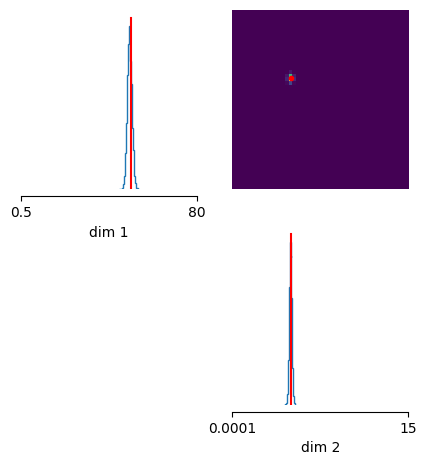

In [15]:
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.5, 80], [1e-4, 15.0]],
    ticks=[[0.5, 80], [1e-4, 15.0]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
);

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

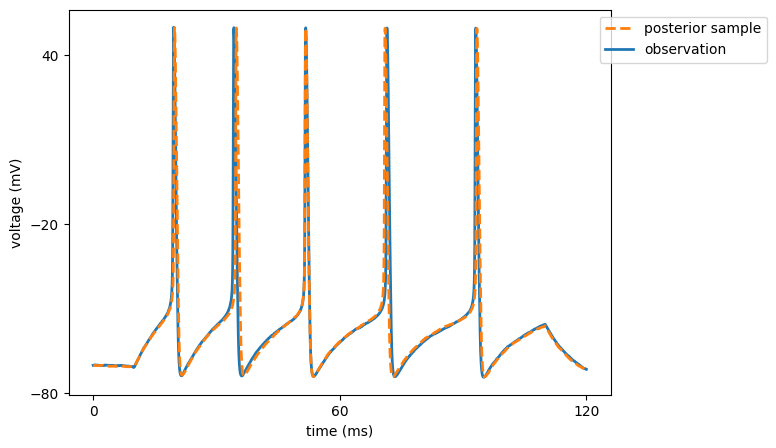

In [17]:
posterior_sample = posterior.sample((1,), x=observation_summary_statistics).numpy()
posterior_sample

fig = plt.figure(figsize=(7, 5))

# plot observation
t = observation_trace["time"]
y_obs = observation_trace["data"]
plt.plot(t, y_obs, lw=2, label="observation")

# simulate and plot samples
x = run_HH_model(posterior_sample)
plt.plot(t, x["data"], "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

ax.set_xticks([0, 60, 120])
ax.set_yticks([-80, -20, 40]);

## analyse code of SNPE and posterior estimator